# Generate Probability of Detection for Operators
Code author: Sahar H. El Abbadi
Date started: 2022-02-23
Date last edited: 2022-05-19

This notebook generates individual probability of detection plots for each operator. Number of bins and the maximum value ("threshold") for the probability of detection plot can be adjusted in each cell.

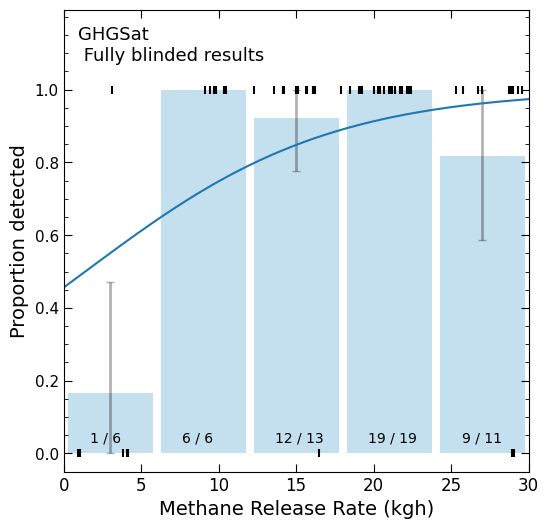

In [1]:
from plot_methods import plot_detection_limit, save_pod_plot, plot_logistic_regression
import matplotlib.pyplot as plt

# GHGSat probability of detection
operator = 'GHGSat'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'ms'
n_bins = 5
threshold = 30

fig, ax = plt.subplots(1, figsize=(6, 6))


ax = plot_detection_limit(ax, operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
ax = plot_logistic_regression(ax, threshold=threshold, operator=operator, stage=stage, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
save_pod_plot(operator, stage, strict_discard, time_ave, gas_comp_source)


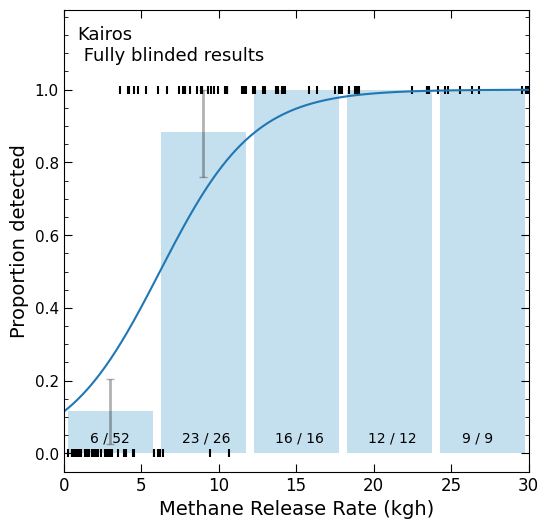

In [2]:
# Kairos probability of detection
import matplotlib.pyplot as plt
from plot_methods import plot_detection_limit, save_pod_plot, plot_logistic_regression

operator = 'Kairos'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'ms'
n_bins = 5
threshold = 30

fig, ax = plt.subplots(1, figsize=(6, 6))

ax = plot_detection_limit(ax, operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
ax = plot_logistic_regression(ax, threshold=threshold, operator=operator, stage=stage, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
save_pod_plot(operator, stage, strict_discard, time_ave, gas_comp_source)



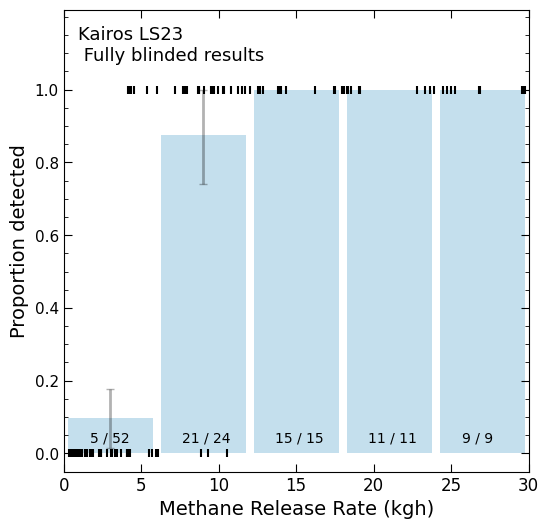

In [13]:
# Kairos LS23 probability of detection
import matplotlib.pyplot as plt
from plot_methods import plot_detection_limit, save_pod_plot

operator = 'Kairos LS23'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'ms'
n_bins = 5
threshold = 30

fig, ax = plt.subplots(1, figsize=(6, 6))

plot_detection_limit(ax, operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
save_pod_plot(operator, stage, strict_discard, time_ave, gas_comp_source)


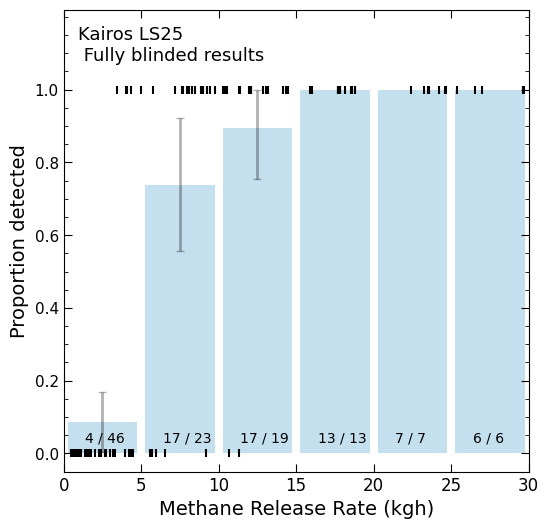

In [14]:
# Kairos probability of detection
import matplotlib.pyplot as plt
from plot_methods import plot_detection_limit, save_pod_plot

operator = 'Kairos LS25'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'ms'
n_bins = 6
threshold = 30

fig, ax = plt.subplots(1, figsize=(6, 6))

plot_detection_limit(ax, operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
save_pod_plot(operator, stage, strict_discard, time_ave, gas_comp_source)

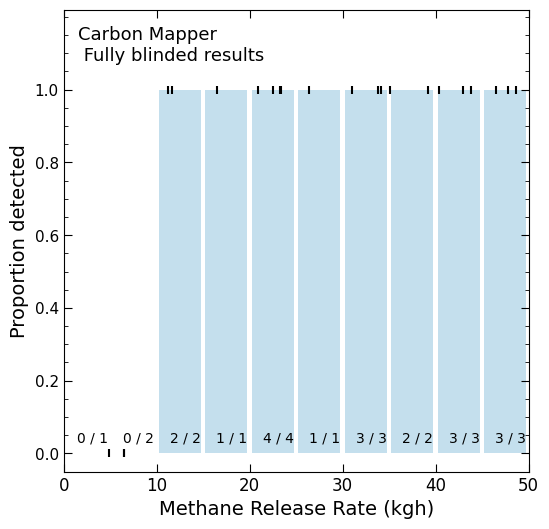

In [15]:
# Carbon Mapper probability of detection
from plot_methods import plot_detection_limit, save_pod_plot
import matplotlib.pyplot as plt

operator = 'Carbon Mapper'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'ms'
n_bins = 10
threshold = 50
fig, ax = plt.subplots(1, figsize=(6, 6))

plot_detection_limit(ax, operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
save_pod_plot(operator, stage, strict_discard, time_ave, gas_comp_source)


/Users/sea/PycharmProjects/CRF22_Airplanes/plot_methods.py:342: RuntimeWarning: invalid value encountered in scalar divide
  p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows


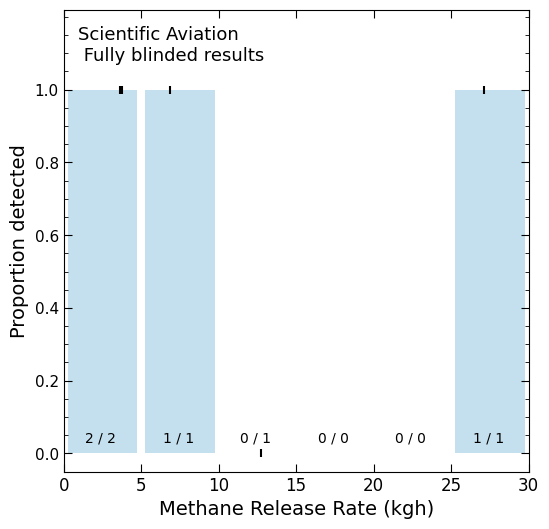

In [16]:
# Scientific Aviation
from plot_methods import plot_detection_limit, save_pod_plot
import matplotlib.pyplot as plt

operator = 'Scientific Aviation'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'ms'
n_bins = 6
threshold = 30

fig, ax = plt.subplots(1, figsize=(6, 6))


plot_detection_limit(ax, operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
save_pod_plot(operator, stage, strict_discard, time_ave, gas_comp_source)


/Users/sea/PycharmProjects/CRF22_Airplanes/plot_methods.py:342: RuntimeWarning: invalid value encountered in scalar divide
  p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows


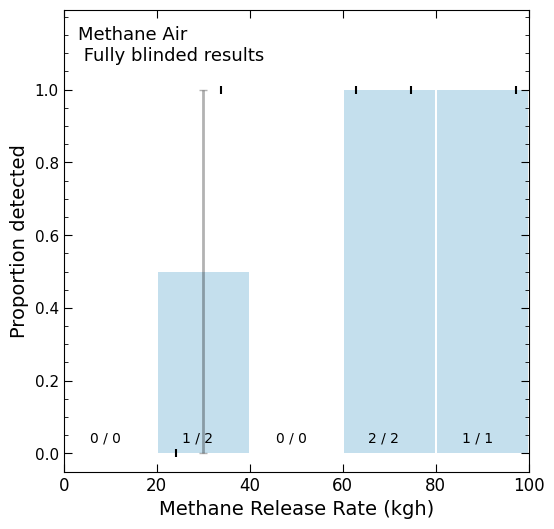

In [17]:
 # Methane Air probability of detection
from plot_methods import plot_detection_limit, save_pod_plot
import matplotlib.pyplot as plt

operator = 'Methane Air'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'ms'
n_bins = 5
threshold = 100

fig, ax = plt.subplots(1, figsize=(6, 6))

plot_detection_limit(ax, operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
save_pod_plot(operator, stage, strict_discard, time_ave, gas_comp_source)


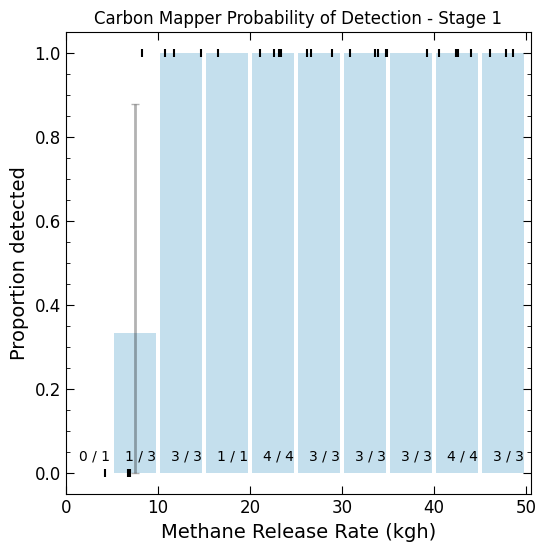

Your operator is: Kairos.
Only use this function with Carbon Mapper or Scientific Aviation, as their QC only applies to quantification.
For all other operators, please use standard plot_detection_limit function.


In [18]:
import matplotlib.pyplot as plt
from plot_methods import plot_detection_limit_su_filter_only


# Carbon Mapper: plot that includes ALL their data points regardless of quantification QC
# Note: saves with suffix: su_filter_only
plot_detection_limit_su_filter_only('Carbon Mapper', stage=1, n_bins=10, threshold=50)
plot_detection_limit_su_filter_only('Kairos', stage=1, n_bins=10, threshold=50)

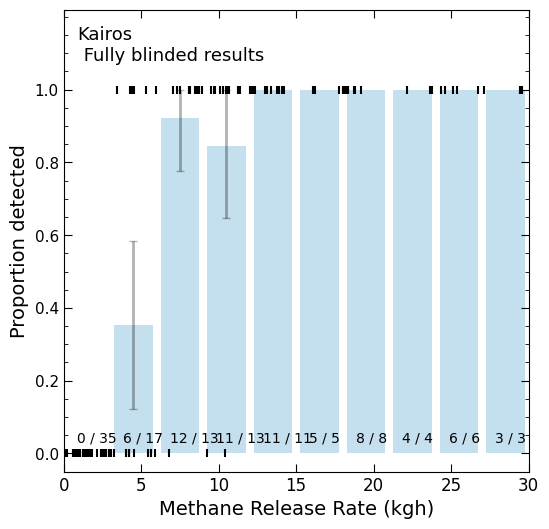

In [19]:
# Plot Kairos with more bins

from plot_methods import plot_detection_limit, save_pod_plot
operator = 'Kairos'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'ms'

# Set desired number of bins:
n_bins = 10
threshold = 30

fig, ax = plt.subplots(1, figsize=(6, 6))

plot_detection_limit(ax, operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)
save_pod_plot(operator, stage, strict_discard, time_ave, gas_comp_source)
